In [1]:
from sbibm.metrics.c2st import c2st
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import torch
from torch import distributions as dist
import numpy as np
import jax.numpy as jnp
import jax.random as random
from rsnl.examples.contaminated_normal import (get_prior, assumed_dgp,
                                               calculate_summary_statistics,
                                               true_dgp, true_posterior)

/Users/ryankelly/python_projects/rsnl/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_reference_samples(x_obs):
    prior = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([10.0]))

    # Conjugate prior with known variance
    n_obs = 100
    true_dgp_var = 1.0
    prior_var = prior.variance
    obs_mean = x_obs[0]

    true_post_var = (1/prior_var + n_obs/true_dgp_var) ** -1
    true_post_mu = (true_post_var *
                    (prior.mean/prior_var + ((obs_mean * n_obs) / true_dgp_var)))
    true_post_std = torch.sqrt(true_post_var)
    true_posterior =  dist.Normal(true_post_mu, true_post_std)
    reference_samples = true_posterior.sample((40000,))
    return reference_samples

In [3]:
x_obs = torch.tensor([1.0, 2.0])
get_reference_samples(x_obs).shape

torch.Size([40000, 1])

In [4]:
directory = '../res/contaminated_normal/rsnl/seed_0/'
thetas = pkl.load(open(f'{directory}thetas.pkl', 'rb'))
thetas.shape

(4, 10000, 1)

In [5]:
def get_x_obs(seed):
    rng_key = random.PRNGKey(seed)
    rng_key, sub_key1, sub_key2 = random.split(rng_key, 3)
    sim_fn = assumed_dgp
    sum_fn = calculate_summary_statistics
    true_params = jnp.array([1.0])
    # true_params = prior.sample(sub_key1)
    x_obs_tmp = true_dgp(sub_key2, true_params)
    x_obs = jnp.array(calculate_summary_statistics(x_obs_tmp))
    # Convert JAX array to numpy array
    numpy_x_obs = np.array(x_obs)
    numpy_x_obs[1] = 2.0

    # Convert numpy array to PyTorch tensor
    x_obs = torch.tensor(numpy_x_obs)
    return x_obs

In [6]:
def get_c2st_res(directory=""):
    sub_dirs = [x[0] for x in os.walk(directory)]
    sub_dirs = sub_dirs[1:]
    c2st_res = []
    for ii, sub_dir in enumerate(sub_dirs):
        print(f"ii: {ii}, sub_dir: {sub_dir}")
        try:
            with open(f'{sub_dir}/thetas.pkl', 'rb') as f:
                thetas = pkl.load(f)
                thetas = np.array(thetas)
                thetas = np.concatenate(thetas, axis=0)
                base_name = os.path.basename(sub_dir)
                match = re.search(r'seed_(\d+)', base_name)
                seed = int(match.group(1))
                print('seed ', seed)
                x_obs = get_x_obs(seed=seed)
                print('x_obs ', x_obs)
                algorithm_samples = torch.as_tensor(thetas).reshape(-1, 1)
                reference_samples = get_reference_samples(x_obs).reshape(-1, 1)
                c2st_ii = c2st(algorithm_samples, reference_samples)
                print(f"c2st_ii: {c2st_ii}")
                c2st_res.append(c2st_ii)
        except Exception as e:
            print(e)
            print(f"Error with {sub_dir}")

    return c2st_res

In [7]:
directory = "../res/contaminated_normal/rsnl/"
c2st_rsnl = get_c2st_res(directory=directory)

ii: 0, sub_dir: ../res/contaminated_normal/rsnl/seed_156
seed  156
x_obs  tensor([1.2247, 2.0000])
c2st_ii: tensor([0.5197])
ii: 1, sub_dir: ../res/contaminated_normal/rsnl/seed_169
seed  169
x_obs  tensor([1.2033, 2.0000])
c2st_ii: tensor([0.5462])
ii: 2, sub_dir: ../res/contaminated_normal/rsnl/seed_151
seed  151
x_obs  tensor([1.0426, 2.0000])
c2st_ii: tensor([0.5296])
ii: 3, sub_dir: ../res/contaminated_normal/rsnl/seed_167
seed  167
x_obs  tensor([0.8442, 2.0000])
c2st_ii: tensor([0.5157])
ii: 4, sub_dir: ../res/contaminated_normal/rsnl/seed_193
seed  193
x_obs  tensor([1.1611, 2.0000])
c2st_ii: tensor([0.5195])
ii: 5, sub_dir: ../res/contaminated_normal/rsnl/seed_158
seed  158
x_obs  tensor([0.9905, 2.0000])
c2st_ii: tensor([0.5183])
ii: 6, sub_dir: ../res/contaminated_normal/rsnl/seed_194
seed  194
x_obs  tensor([0.7322, 2.0000])
c2st_ii: tensor([0.5270])
ii: 7, sub_dir: ../res/contaminated_normal/rsnl/seed_160
seed  160
x_obs  tensor([0.8498, 2.0000])
c2st_ii: tensor([0.5240])


In [12]:
c2st_rsnl = np.concatenate(c2st_rsnl)

<Axes: >

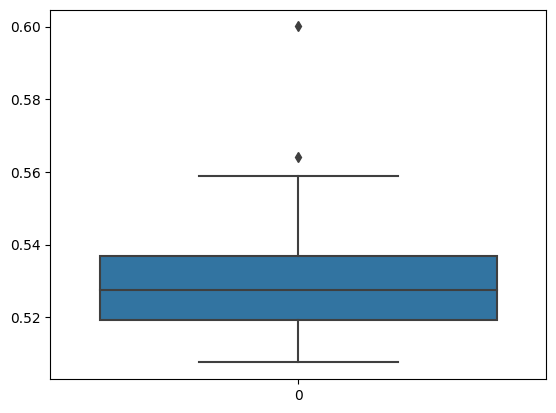

In [13]:
sns.boxplot(c2st_rsnl)

In [14]:
directory = "../res/contaminated_normal/snl/"
c2st_snl = get_c2st_res(directory=directory)

ii: 0, sub_dir: ../res/contaminated_normal/snl/seed_156
seed  156
x_obs  tensor([1.2247, 2.0000])
c2st_ii: tensor([0.9954])
ii: 1, sub_dir: ../res/contaminated_normal/snl/seed_169
seed  169
x_obs  tensor([1.2033, 2.0000])
c2st_ii: tensor([0.8597])
ii: 2, sub_dir: ../res/contaminated_normal/snl/seed_151
seed  151
x_obs  tensor([1.0426, 2.0000])
c2st_ii: tensor([0.9979])
ii: 3, sub_dir: ../res/contaminated_normal/snl/seed_167
seed  167
x_obs  tensor([0.8442, 2.0000])
c2st_ii: tensor([0.9678])
ii: 4, sub_dir: ../res/contaminated_normal/snl/seed_193
seed  193
x_obs  tensor([1.1611, 2.0000])
c2st_ii: tensor([0.9970])
ii: 5, sub_dir: ../res/contaminated_normal/snl/seed_158
seed  158
x_obs  tensor([0.9905, 2.0000])
c2st_ii: tensor([0.9939])
ii: 6, sub_dir: ../res/contaminated_normal/snl/seed_194
seed  194
x_obs  tensor([0.7322, 2.0000])
c2st_ii: tensor([0.9986])
ii: 7, sub_dir: ../res/contaminated_normal/snl/seed_160
seed  160
x_obs  tensor([0.8498, 2.0000])
c2st_ii: tensor([0.7140])
ii: 8, s

In [18]:
c2st_snl = np.concatenate(c2st_snl)

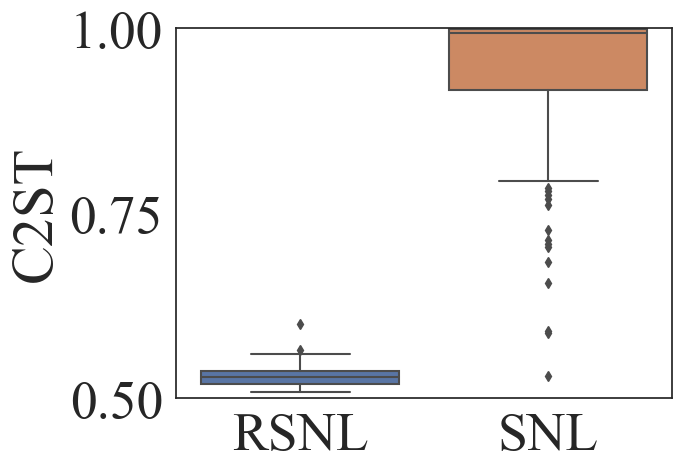

In [35]:
import pandas as pd
df = pd.DataFrame()
df['C2ST'] = np.concatenate([c2st_rsnl, c2st_snl])
df['Method'] = ['RSNL'] * len(c2st_rsnl) + ['SNL'] * len(c2st_snl)
sns.set(font_scale=3.5, font='Times New Roman', style='white')
        # xlabel='', ylabel='Log density')
plt.ylim(0.5, 1)
plt.yticks([0.5, 0.75, 1.0])
# fig, ax = plt.subplots()
# ax = sns.boxplot(x='method', y='logprob', data=df, showfliers = False, ax=axs[i])

sns.boxplot(x='Method', y='C2ST', data=df)
plt.xlabel("")
plt.savefig('c2st.pdf', bbox_inches='tight')